# **AI Research Helper Chatbot**



#🚀Introduction
The AI Research Helper Chatbot is a Streamlit-powered chatbot designed to assist users in discovering relevant research papers. This chatbot was developed by Team 3 for CSE 6550: Software Engineering Concepts at California State University, San Bernardino (CSUSB).

In this notebook, we show how the chatbot uses retrieval-augmented generation (RAG) to answer questions based on research papers, academic sources, and AI datasets. It combines FAISS for finding relevant information, SentenceTransformers for understanding text, and LangChain for smooth conversations.

# Table of Contents

1. 📦 [Step 1: Setting up the environment](#Step-1)  
2. 📚 [Step 2: All imports](#Step-2)  
3. 🔑 [Step 3: Accessing data from google drive](#Step-3)  
4. 📂 [Step 4: API key configuration](#Step-4)  
5. 🔢 [Step 5: Chat model setup](#Step-5)  
6. 🧠 [Step 6: Paths and state initialization](#Step-6)  
7. 🤖 [Step 7: Building the vector database](#Step-7)
8. 📚 [Step 8: Vector database management](#Step-8)
9. 🔑 [Step 9: Similarity search and ranking](#Step-9)
10. 📂 [Step 10: Simulating AI-to-AI dialogue](#Step-10)
11. 🔢 [Step 11: User chatbot interface](#Step-11)
12. 🧠 [Step 12: Performance metrics](#Step-12)
13. 📦 [Step 13: Execute AI-to-AI dialogue](#Step-13)
14. 🤖 [Step 14: Launch user interaction](#Step-14)

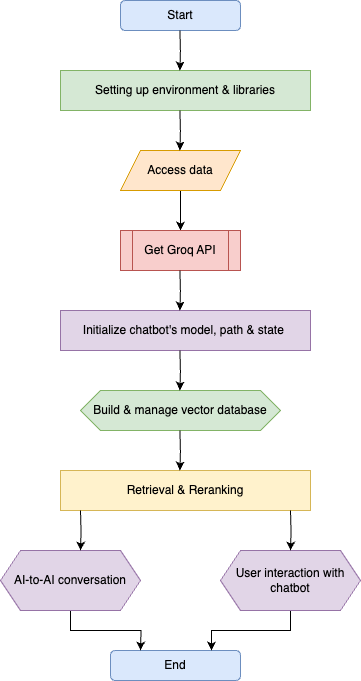

# <a name="Step-1"></a> 📦 Step 1: Setting up the environment
This step installs required libraries for the chatbot to function in Colab.
- langchain: Provides tools for building language model applications.
- sentence-transformers: Generates text embeddings for vector search.
- faiss-cpu: Enables efficient similarity search in high-dimensional spaces.
- langchain-groq: Integrates with the Groq API for chat model access.
- pandas & numpy: Manage data processing and numerical computations.
- IPython: Enhances display capabilities in Colab.

In [ ]:
# Cell 1: Install Dependencies
!pip install langchain sentence-transformers faiss-cpu langchain-groq pandas numpy IPython


# <a name="Step-2"></a> 📚 Step 2: All imports
This step imports essential libraries for the chatbot.
- numpy & pandas: Handle numerical operations and data manipulation.
- os: Interacts with the operating system for file paths and environment variables.
- langchain.chat_models & schema: Manage chat model initialization and message types.
- faiss: Performs fast similarity searches on large datasets.
- SentenceTransformer: Converts text into embeddings for similarity comparison.
- IPython.display: Formats output with Markdown in Colab.
- google.colab.files: Enables file uploads in Colab.


In [ ]:
# Cell 2: Import Libraries
import numpy as np
import pandas as pd
import os
from langchain.chat_models import init_chat_model
from langchain.schema import SystemMessage, HumanMessage, AIMessage
import faiss
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
import time
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
from google.colab import files

# <a name="Step-3"></a> 🔑 Step 3: Accessing data from Google Drive
This step mounts Google Drive to read files directly without manual upload.

- google.colab.drive: Connects Colab to your Google Drive.
- Drive path: Files are accessible under /content/drive/My Drive/.


In [ ]:
# Cell 3: Mount Google Drive
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Confirm mounting (optional)
print("Google Drive mounted successfully!")

# <a name="Step-4"></a> 📂 Step 4: Set Up API Key
This step securely collects and sets the GROQ_API_KEY for chat model access.
- input(): Prompts the user to enter the API key manually.
- os.environ: Stores the key as an environment variable.
- Validation ensures the key is provided before proceeding.

In [ ]:
# Cell 4: Set Up API Key (Manual Input in Colab)
api_key = input("Please enter your GROQ_API_KEY: ")
os.environ["GROQ_API_KEY"] = api_key

if not api_key:
    raise ValueError("GROQ_API_KEY is not set.")


# <a name="Step-5"></a> 🔢 Step 5: Chat model setup
This step initializes the language model for chatbot interactions.
- init_chat_model(): Configures the Groq-provided "llama3-8b-8192" model.
- This model powers both user queries and AI-to-AI conversations.

In [ ]:
# Cell 5: Initialize Chat Model
chat = init_chat_model("llama3-8b-8192", model_provider="groq")

# <a name="Step-6"></a> 🧠 Step 6: Paths and state initialization
This step sets file paths and global variables for the chatbot.
- Paths: Define locations for data files in Colab’s /content/ directory.
- Variables: Simulate Streamlit’s session state with messages, confusion matrix, etc.
- Global scope ensures accessibility across functions.

In [ ]:
# Cell 6: Define Paths and Global Variables
# Paths in Google Drive (adjust based on your file location)
is_new_papers_path = "/content/drive/My Drive/is_new_pdfs.txt"
faiss_index_file_path = "/content/drive/My Drive/faiss_index.index"
chunks_file_path = "/content/drive/My Drive/chunks.txt"
output_file_path = "/content/drive/My Drive/papers_output.csv"  # Update this to your file’s path in Drive
is_new_vector_database = True
model = None
index = None
chunks = []

messages = [SystemMessage(content="Hey, I'm an AI research helper. Feel free to ask me anything about AI research.")]
conf_matrix = np.zeros((2, 2), dtype=int)
conversation_history = []
last_ai_response = None


# <a name="Step-7"></a> 🤖 Step 7: Building the vector database
This step creates a FAISS index from uploaded text data for similarity search.
- pd.read_csv(): Loads text from papers_output.csv.
- RecursiveCharacterTextSplitter: Breaks text into manageable chunks.
- SentenceTransformer: Generates embeddings for each chunk.
- faiss: Indexes embeddings for fast retrieval.


In [ ]:
# Cell 7: Vector Database Creation Function

def create_vector_database():
    global model, chunks, index

    # Check if the file exists in Drive
    if not os.path.exists(output_file_path):
        raise ValueError(f"CSV file not found at {output_file_path}. Please ensure 'papers_output.csv' is in your Google Drive.")

    df = pd.read_csv(output_file_path)
    if 'text' not in df.columns:
        raise ValueError("CSV file must have a 'text' column")

    sentences = df['text'].tolist()
    csv_text = " ".join(sentences)

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=50)
    chunks = text_splitter.split_text(csv_text)

    model = SentenceTransformer('all-MiniLM-L6-v2')

    with open(chunks_file_path, 'w') as f:
        for chunk in chunks:
            f.write(chunk + '\n')

    embeddings = model.encode(chunks).astype('float32')
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    faiss.write_index(index, faiss_index_file_path)


# <a name="Step-8"></a> 📚 Step 8: Vector database management
This step decides whether to load an existing database or create a new one.
- Checks is_new_pdfs.txt to determine if a new database is needed.
- Loads pre-existing FAISS index and chunks if available.
- Falls back to creating a new database if files are missing.


In [ ]:
# Cell 8: Load or Create Vector Database
if os.path.exists(is_new_papers_path):
    with open(is_new_papers_path, 'r') as txtfile:
        first_line = txtfile.readline().strip()
        if first_line and first_line[0] == '0':
            is_new_vector_database = False
        elif first_line and first_line[0] == '1':
            is_new_vector_database = True

if is_new_vector_database:
    create_vector_database()
else:
    if os.path.exists(faiss_index_file_path):
        model = SentenceTransformer('all-MiniLM-L6-v2')
        with open(chunks_file_path, 'r') as f:
            chunks = [line.strip() for line in f]
        index = faiss.read_index(faiss_index_file_path)
    else:
        create_vector_database()

# <a name="Step-9"></a> 🔑 Step 9: Similarity search and ranking
This step defines functions to retrieve and refine context for responses.
- retrieve_similar_sentences(): Uses FAISS to find top-k similar text chunks.
- rerank_sentences(): Employs the LLM to score and sort retrieved sentences.
- Handles rate limits with retries for robust operation.


In [ ]:
# Cell 9: Retrieval and Reranking Functions
def retrieve_similar_sentences(query_sentence, k=3):
    query_embedding = model.encode(query_sentence).astype('float32').reshape(1, -1)
    distances, indices = index.search(query_embedding, k)
    similar_sentences = [chunks[indices[0][i]] for i in range(min(k, len(indices[0])))]
    return similar_sentences, distances[0].tolist()

def rerank_sentences(query, sentences):
    rerank_prompt = (
        "You are an AI tasked with ranking sentences based on their relevance to a query. "
        "For each sentence, provide a relevance score between 0 and 1 (where 1 is highly relevant) "
        "and a brief explanation. Return the results in this format:\n"
        "Sentence: <sentence>\nScore: <score>\nExplanation: <explanation>\n\n"
        "Query: '{}'\n\n"
        "Sentences to rank:\n{}"
    ).format(query, "\n".join([f"{i+1}. {s}" for i, s in enumerate(sentences)]))

    max_retries = 3
    retry_delay = 60

    for attempt in range(max_retries):
        try:
            response = chat.invoke([HumanMessage(content=rerank_prompt)])
            reranked = []
            lines = response.content.strip().split("\n")
            for i in range(0, len(lines), 3):
                try:
                    sentence = lines[i].replace("Sentence: ", "").strip()
                    score = float(lines[i+1].replace("Score: ", "").strip())
                    reranked.append((sentence, score))
                except (IndexError, ValueError):
                    continue
            reranked.sort(key=lambda x: x[1], reverse=True)
            return reranked
        except Exception as e:
            if "rate_limit_exceeded" in str(e) and attempt < max_retries - 1:
                print(f"Rate limit exceeded. Waiting {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                raise e
    return []

# <a name="Step-10"></a> 📂 Step 10: Simulating AI-to-AI dialogue
This step runs a predefined conversation between two AI personas.
- Alpha: Rephrases research questions.
- Beta: Answers using retrieved and reranked context.
- Updates confusion matrix based on answer quality.

In [ ]:
# Cell 10: AI-to-AI Conversation Function
def ai_to_ai_conversation():
    global conf_matrix, conversation_history
    original_questions = [
        "What is the main advantage of using Curvature-based Feature Selection (CFS) over PCA for dimensionality reduction?",
        "How does the Inception-ResNet-v2 model contribute to feature extraction in breast tumor classification?",
        "What are the key classifiers used in the ensemble method for breast tumor classification, and why were they chosen?",
        "How does Menger Curvature help in ranking features in Electronic Health Records (EHR) data classification?",
        "What are the main challenges in handling missing data in medical datasets, and how does the first paper address this issue?",
        "How does the performance of CFS compare to other feature selection methods on completely different datasets outside the ones mentioned?",
        "What specific preprocessing steps were used for data normalization in each classification experiment?",
        "How would the proposed breast cancer classification model perform on a realtime clinical setup?",
        "Can the Curvature-based Feature Selection method be adapted to non-medical domains like finance or cybersecurity?",
        "How does the ensemble of CatBoost, XGBoost, and LightGBM compare to deep learning models trained end-to-end on histopathology images?"
    ]
    alpha_prompt = "You are Alpha, an AI researcher. Provide only the rephrased version of this question, keeping its meaning the same, without any additional text: '{}'"
    beta_prompt = "You are Beta, an AI assistant. Using the provided context, generate a concise answer to the following question: '{}'"

    conversation_history = []
    for i, original_question in enumerate(original_questions):
        is_answerable = i < 5
        print(f"Processing question {i+1}/{len(original_questions)}...")

        alpha_input = alpha_prompt.format(original_question)
        response_alpha = chat.invoke([HumanMessage(content=alpha_input)])
        rephrased_question = response_alpha.content.strip().split('\n')[0].strip()
        conversation_history.append(("user", f"**Alpha:** {rephrased_question}"))
        display(Markdown(f"**Alpha:** {rephrased_question}"))

        similar_sentences, _ = retrieve_similar_sentences(rephrased_question, k=3)
        if not similar_sentences:
            beta_answer = "No context available."
        else:
            reranked = rerank_sentences(rephrased_question, similar_sentences)
            context = reranked[0][0] if reranked else "No context available."
            beta_input = beta_prompt.format(rephrased_question)
            response_beta = chat.invoke([SystemMessage(content=f"Context: {context}"), HumanMessage(content=beta_input)])
            beta_answer = response_beta.content.strip()

        conversation_history.append(("assistant", f"**Beta:** {beta_answer}"))
        display(Markdown(f"**Beta:** {beta_answer}"))

        if is_answerable and "No context available" not in beta_answer:
            conf_matrix[0, 0] += 1  # TP
        elif is_answerable and "No context available" in beta_answer:
            conf_matrix[0, 1] += 1  # FN
        elif not is_answerable and "No context available" in beta_answer:
            conf_matrix[1, 1] += 1  # TN
        else:
            conf_matrix[1, 0] += 1  # FP

        time.sleep(0.5)
    print("AI-to-AI conversation completed!")

# <a name="Step-11"></a> 🔢 Step 11: User chatbot interface
This step enables interactive chatting with the AI research helper.
- input(): Collects user queries in a loop.
- Uses retrieval and reranking to provide context-aware responses.
- Allows rating of responses to update the confusion matrix.

In [ ]:
# Cell 11: Chatbot Interaction Loop
def chat_interaction():
    global messages, last_ai_response, conf_matrix
    while True:
        user_input = input("Type your message (or 'exit' to stop): ")
        if user_input.lower() == 'exit':
            break

        messages.append(HumanMessage(content=user_input))
        display(Markdown(f"**You:** {user_input}"))

        similar_sentences, _ = retrieve_similar_sentences(user_input, k=3)
        if not similar_sentences:
            context = "No context available."
        else:
            reranked = rerank_sentences(user_input, similar_sentences)
            context = reranked[0][0] if reranked else "No context available."

        messages_to_send = messages + [SystemMessage(content=f"Context: {context}")]
        response = chat.invoke(messages_to_send)
        ai_message = AIMessage(content=response.content)
        messages.append(ai_message)
        last_ai_response = ai_message.content
        display(Markdown(f"**AI:** {last_ai_response}"))

        rating = input("Rate the response (correct/incorrect): ").lower()
        if rating == "correct":
            conf_matrix[0, 0] += 1
            print("Thank you for your feedback!")
        elif rating == "incorrect":
            conf_matrix[0, 1] += 1
            print("Thank you for your feedback! We will improve.")

        display_conf_matrix()

# <a name="Step-12"></a> 🧠 Step 12: Performance metrics
This step displays the confusion matrix and calculated metrics.  
- Confusion matrix: Tracks true/false positives/negatives.
- Metrics: Sensitivity, specificity, accuracy, precision, F1 score.
- Uses pandas and Markdown for clear presentation.

In [ ]:
# Cell 12: Display Confusion Matrix
from IPython.display import display, Markdown  # Ensure imports are present
import pandas as pd
import numpy as np

def display_conf_matrix():
    global conf_matrix
    TP, FN, FP, TN = conf_matrix.ravel()
    sensitivity = TP / (TP + FN) if (TP + FN) else 0
    specificity = TN / (TN + FP) if (TN + FP) else 0
    accuracy = (TP + TN) / np.sum(conf_matrix) if np.sum(conf_matrix) else 0
    precision = TP / (TP + FP) if (TP + FP) else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) else 0

    # Display the confusion matrix and metrics
    display(Markdown("### Confusion Matrix"))
    display(pd.DataFrame(conf_matrix, index=["True Answerable", "True Unanswerable"],
                         columns=["Predicted Answerable", "Predicted Unanswerable"]))
    display(Markdown(f"**Sensitivity:** {sensitivity:.2f}"))
    display(Markdown(f"**Specificity:** {specificity:.2f}"))
    display(Markdown(f"**Accuracy:** {accuracy:.2f}"))
    display(Markdown(f"**Precision:** {precision:.2f}"))
    display(Markdown(f"**F1 Score:** {f1_score:.2f}"))

# Explicitly call the function to display output when running this cell
display_conf_matrix()

# <a name="Step-13"></a> 📦 Step 13: Execute AI-to-AI dialogue
This step triggers the predefined AI-to-AI conversation.
- Runs the ai_to_ai_conversation() function to simulate research dialogue.
- Outputs results directly in the notebook.

In [ ]:
# Cell 13: Run AI-to-AI Conversation
ai_to_ai_conversation()

# <a name="Step-14"></a> 🤖 Step 14: Launch user interaction
This step starts the interactive chatbot session.
- Runs chat_interaction() to allow real-time user queries.
- Continues until the user types 'exit'.

In [ ]:
# Cell 14: Start Chatbot Interaction
chat_interaction()